# Logistic Regression

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1. In logistic regression, a logit transformation is applied on the odds—that is, the probability of success divided by the probability of failure. This is also commonly known as the log odds, or the natural logarithm of odds, and this logistic function is represented by the following formulas:

$ f(x) = \cfrac{1}{1 + e^{-x}} $

$ x = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + ... + \beta_n \cdot x_n $

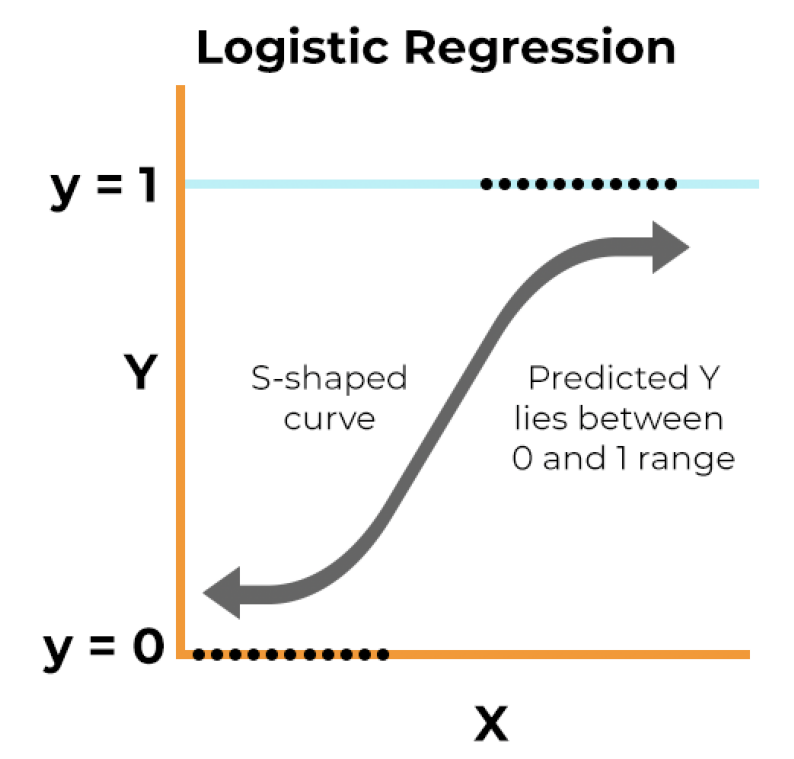

In [4]:
display_img('Logistic_Regression.png', 10, 10)

In [5]:
start = time.time()

# 1. Preprocessing

### i. Read Dataframe

In [6]:
df = pd.read_csv('credit_risk.csv')

In [7]:
cat_str = ['person_home_ownership', 'loan_intent']
cat_oh = ['cb_person_default_on_file', 'loan_grade']

num_mean = ['person_age', 'person_income', 'loan_percent_income']

num_mean_nan = ['loan_int_rate', 'person_emp_length']
num_zero_nan = ['loan_amnt']

X_cols = cat_str + cat_oh + num_mean + num_mean_nan + num_zero_nan

label = 'loan_status'

### ii. Drop 'y' NaNs

In [8]:
df = df[df[label].notna()]

### iii. Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
features_dict = {
    'cat_str': cat_str,
    'cat_oh': cat_oh,
    'num_mean': num_mean,
    'num_mean_nan': num_mean_nan,
    'num_zero_nan': num_zero_nan
}

In [11]:
X = df[X_cols].copy()
y = df[label].copy()

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.40, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 10)

### iv. Fit preprocess

In [13]:
from preprocessing import *

In [14]:
transformers_pre = get_fit_transfomers(features_dict, X_train, y_train)

In [15]:
y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])

y_val = y_val.reset_index()
y_val = y_val.drop(columns = ['index'])

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ['index'])

In [16]:
X_train = transform_datasets(transformers_pre, features_dict, X_train)

X_val = transform_datasets(transformers_pre, features_dict, X_val)

X_test = transform_datasets(transformers_pre, features_dict, X_test)

### v. Train definitive model

In [17]:
from sklearn.metrics import f1_score

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
threshold = y_val['loan_status'].mean()

In [20]:
clf = LogisticRegression()

In [21]:
clf = clf.fit(X_train, y_train)

In [22]:
y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
y_val_pred_prob = clf.predict_proba(X_val)[:, 1]
y_test_pred_prob = clf.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_pred_prob >= threshold)*1
y_val_pred = (y_val_pred_prob >= threshold)*1
y_test_pred = (y_test_pred_prob >= threshold)*1

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)

In [23]:
print('F1 Train:', round(f1_train*100, 2))
print('F1 Val:', round(f1_val*100, 2))
print('F1 Test:', round(f1_test*100, 2))

F1 Train: 63.45
F1 Val: 63.91
F1 Test: 64.66


### vi. Calibration

In [24]:
from sklearn.isotonic import IsotonicRegression

In [25]:
iso_reg = IsotonicRegression()

In [26]:
iso_reg = iso_reg.fit(y_val_pred_prob, y_val['loan_status'])

In [27]:
y_train_pred_prob_cal = pd.Series(iso_reg.predict(y_train_pred_prob))
f_train = (y_train_pred_prob_cal.notna())

In [28]:
y_val_pred_prob_cal = pd.Series(iso_reg.predict(y_val_pred_prob))
f_val = (y_val_pred_prob_cal.notna())

In [29]:
y_test_pred_prob_cal = pd.Series(iso_reg.predict(y_test_pred_prob))
f_test = (y_test_pred_prob_cal.notna())

### vii. Report Calibration

In [30]:
from sklearn.calibration import calibration_curve

In [31]:
def calibration(y, y_pred):

    scores, probs = calibration_curve(y, y_pred, n_bins = 10, normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
    plt.plot(probs, scores, marker = '.', label = 'Real Calibration')
 
    leg = plt.legend(loc = 'upper left')

    plt.xlabel('Probability on each bin')
    plt.ylabel('Real probability on each bin')

    plt.title('Calibration')
    plt.show()

**Train:**

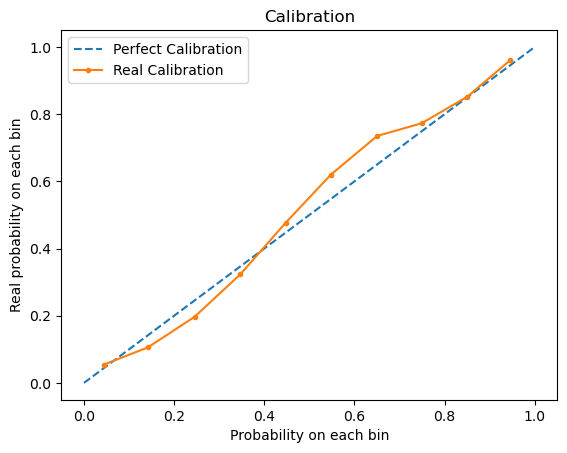

In [32]:
calibration(y_train, y_train_pred_prob)

**Val:**

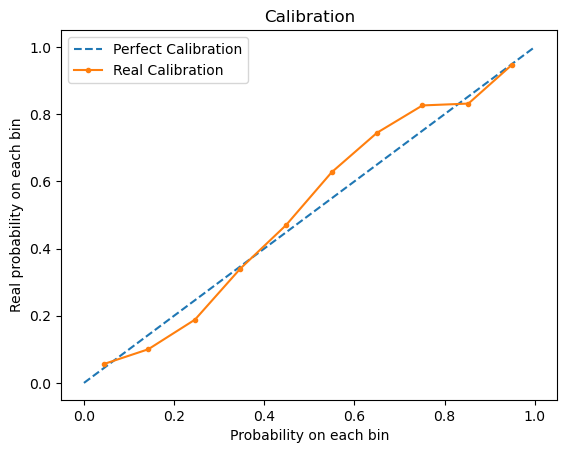

In [33]:
calibration(y_val, y_val_pred_prob)

**Test:**

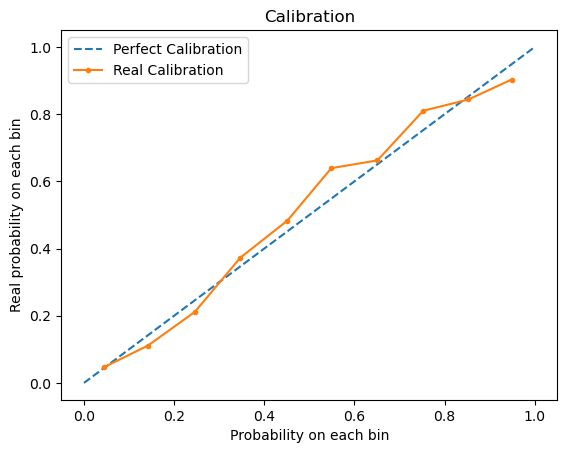

In [34]:
calibration(y_test, y_test_pred_prob)

**Train (Recalibrated):**

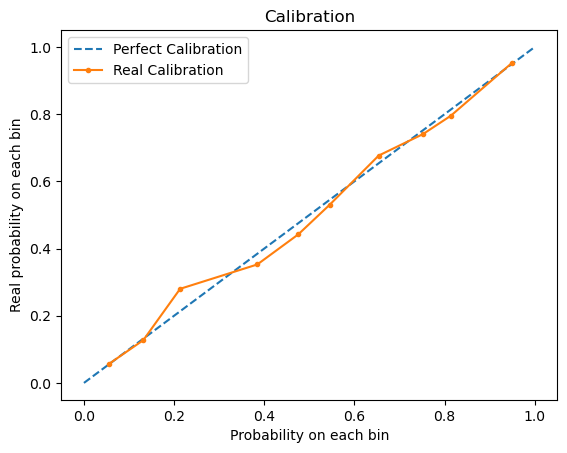

In [35]:
calibration(y_train[f_train], y_train_pred_prob_cal[f_train])

**Val (Recalibrated):**

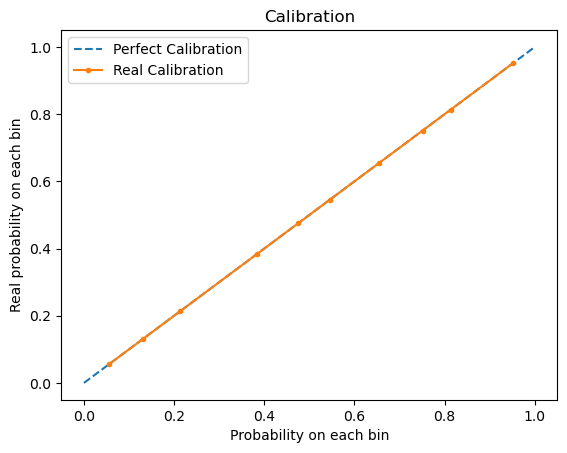

In [36]:
calibration(y_val[f_val], y_val_pred_prob_cal[f_val])

**Test (Recalibrated):**

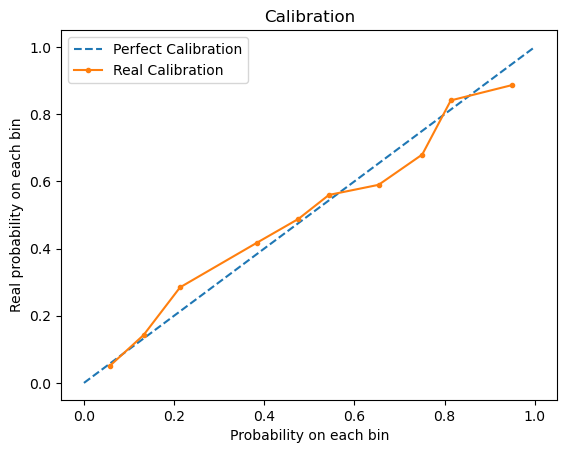

In [37]:
calibration(y_test[f_test], y_test_pred_prob_cal[f_test])

### viii. Confidence Interval

When we have the probabilities $(MP)$ given by a model and the real probabilities $(RP)$ we can define the next random variable:

$ e = RP - MP $

When we have $n$ observations we have:

$ e_i = RP_i - MP_i \ \forall i \in \lbrace 1, ..., n \rbrace $

We can compute $ S $ and $ \bar{e} $ as follows:

$ \bar{e} = \frac{1}{n} \sum_{i=1}^n e_i $

$ S = \sqrt{\cfrac{1}{(n-1)} \cdot \sum_{i=1}^n (e_i - \bar{e})^2} $

Asumming $ e \sim Normal $ we can say that:

$ \bar{e} - S \cdot 1.96 + MP_i \leq RP_i \leq \bar{e} + S \cdot 1.96 + MP_i $     $ \forall i \in \lbrace 1, ..., n \rbrace$  with $ 95 \% $ of confidence.

And also:

$ \bar{e} - \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} \leq \bar{RP} \leq \bar{e} + \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} $  with $ 95 \% $ of confidence.

In [38]:
real_probs_test, model_probs_test = calibration_curve(y_test[f_test], y_test_pred_prob_cal[f_test], n_bins = 20, normalize = True)

In [39]:
df_ci_test = pd.DataFrame(zip(model_probs_test, real_probs_test))
df_ci_test = df_ci_test.rename(columns = {0: 'model_prob', 1: 'real_prob'})
df_ci_test['error'] = df_ci_test['real_prob'] - df_ci_test['model_prob']

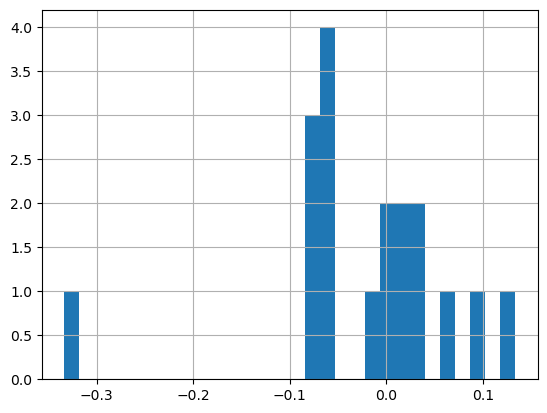

In [40]:
df_ci_test['error'].hist(bins = 30)
plt.show()

**Comments:** The distribution are very similar to a Normal.

In [41]:
bar_e = df_ci_test['error'].mean()
S = df_ci_test['error'].std()

In [42]:
round(bar_e*100, 2), round(S*100, 2)

(-2.35, 9.88)

### ix. Patterns

**Loan Grade vs Loan Status**

In [43]:
X_test['predict'] = y_test_pred

In [44]:
round(X_test[X_test['loan_grade_A'] == 1]['predict'].mean()*100, 2)

11.51

In [45]:
round(X_test[X_test['loan_grade_B'] == 1]['predict'].mean()*100, 2)

23.52

In [46]:
round(X_test[X_test['loan_grade_C'] == 1]['predict'].mean()*100, 2)

31.18

In [47]:
round(X_test[X_test['loan_grade_D'] == 1]['predict'].mean()*100, 2)

91.43

In [48]:
round(X_test[X_test['loan_grade_E'] == 1]['predict'].mean()*100, 2)

94.42

In [49]:
round(X_test[X_test['loan_grade_F'] == 1]['predict'].mean()*100, 2)

92.5

In [50]:
round(X_test[X_test['loan_grade_G'] == 1]['predict'].mean()*100, 2)

100.0

In [51]:
X_test = X_test.drop(columns = ['predict'])

### x. Feature importance

In [52]:
fi = pd.DataFrame(zip(X_train.columns, (abs(clf.coef_)/abs(clf.coef_).sum())[0]))
fi = fi.rename(columns = {0: 'Variable', 1: 'Importance'})
fi['Importance'] = fi['Importance']*100

fi = fi.sort_values(by = ['Importance'], ascending = False)
fi = fi.reset_index()
fi = fi.drop(columns = ['index'])

In [53]:
fi

,Variable,Importance
0,loan_intent,29.655971
1,person_home_ownership,22.370176
2,loan_grade_G,9.253858
3,loan_grade_A,7.220110
4,loan_grade_B,6.688683
5,loan_grade_C,5.805312
6,loan_percent_income,4.574905
7,loan_grade_F,3.155903
8,loan_grade_E,2.159093
9,loan_amnt,2.118820


### xi. Explainability

In [54]:
import shap

In [55]:
explainer = shap.Explainer(clf, X_test, feature_names = X_test.columns)

In [56]:
shap_values = explainer.shap_values(X_test)

In [57]:
df_shap_values = pd.DataFrame(shap_values)

In [58]:
df_shap_values.columns = X_test.columns

**Importance Variable**

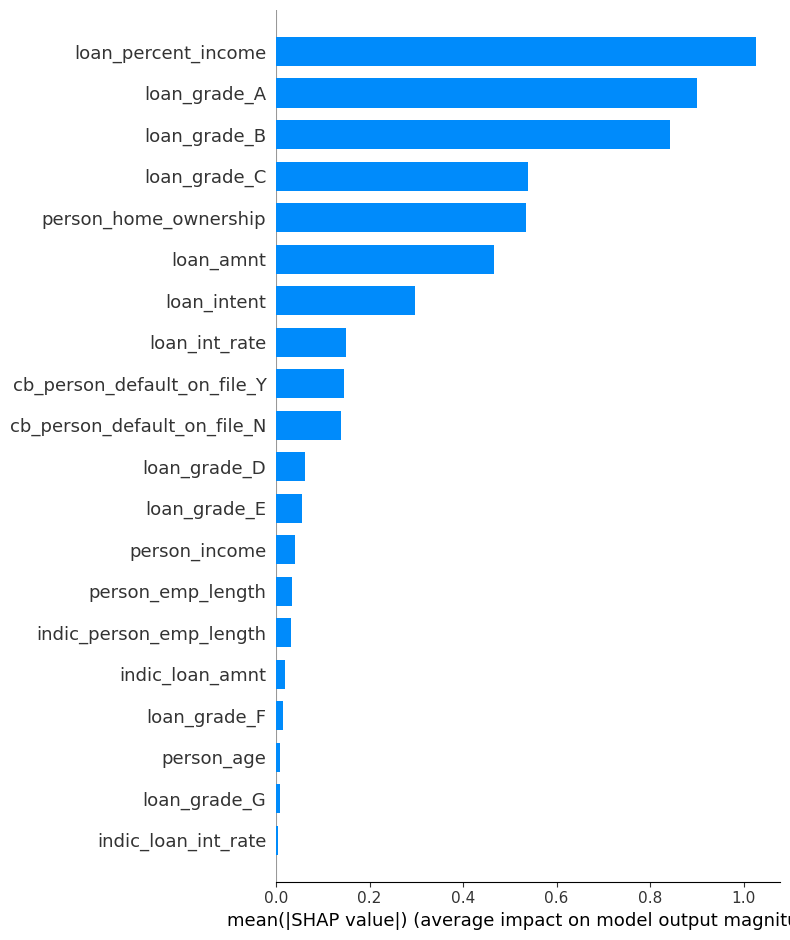

In [59]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [60]:
df_shap_values['partial_sum_SHAP'] = df_shap_values.sum(axis = 1)

In [61]:
df_shap_values = df_shap_values[['partial_sum_SHAP']]

In [62]:
df_shap_values['prob_model'] = y_test_pred_prob

**Sum of SHAP Values**

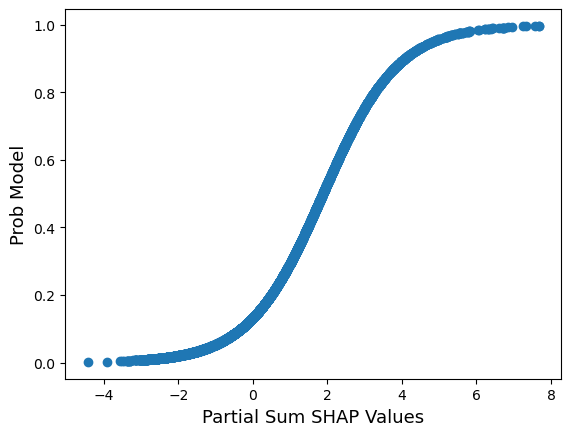

In [63]:
plt.scatter(df_shap_values['partial_sum_SHAP'], df_shap_values['prob_model'])
plt.xlabel('Partial Sum SHAP Values', fontsize = 13)
plt.ylabel('Prob Model', fontsize = 13)
plt.show()

**SHAP dependency**

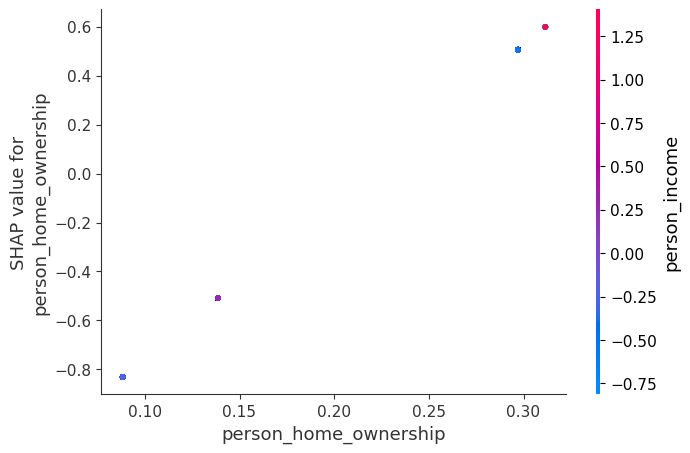

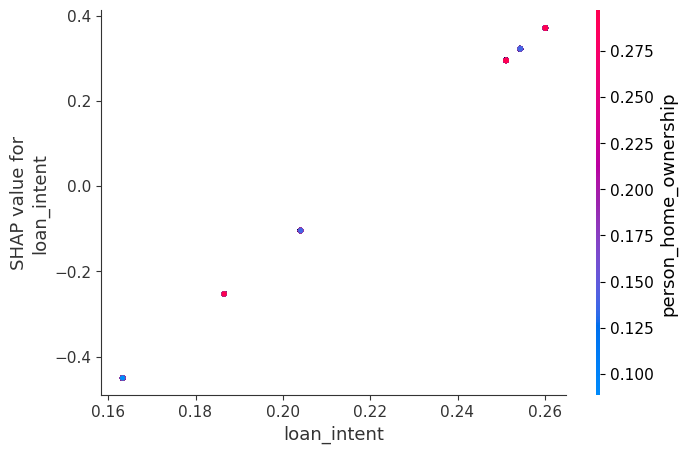

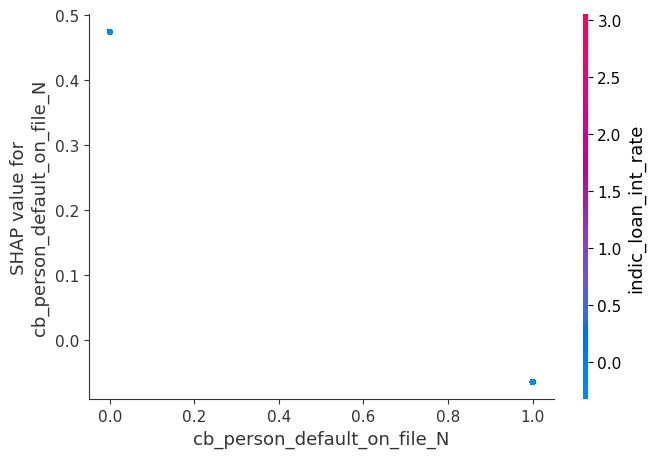

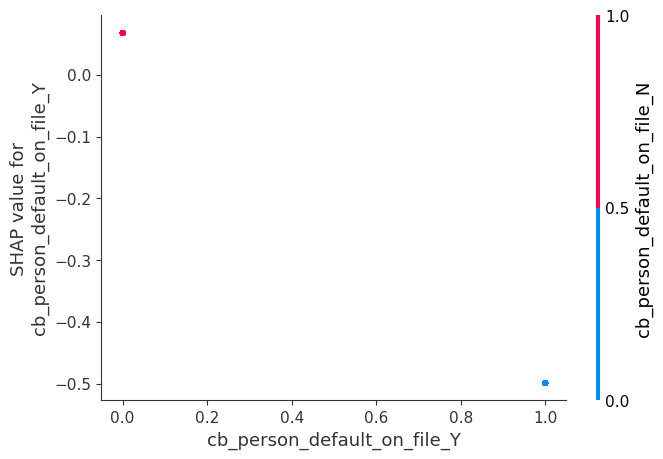

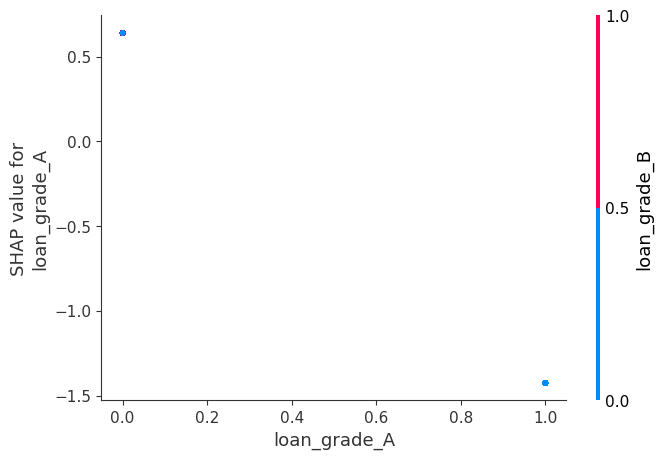

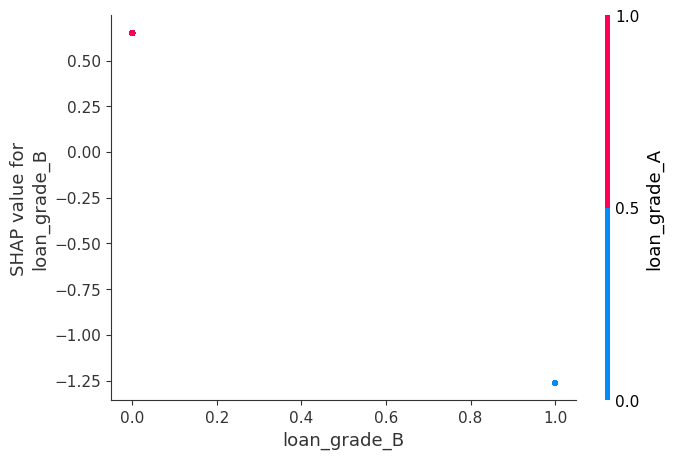

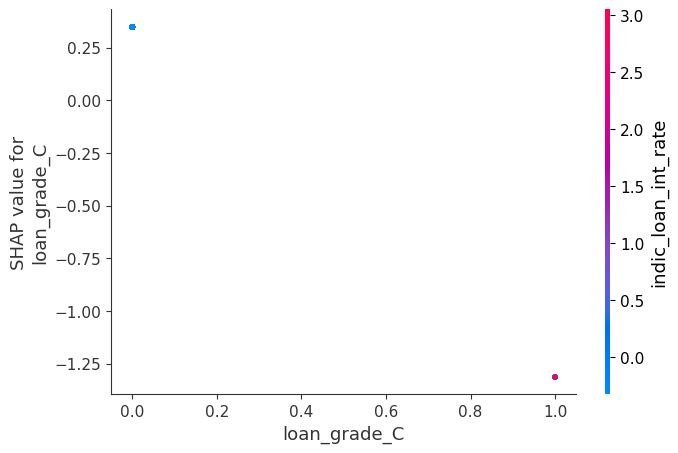

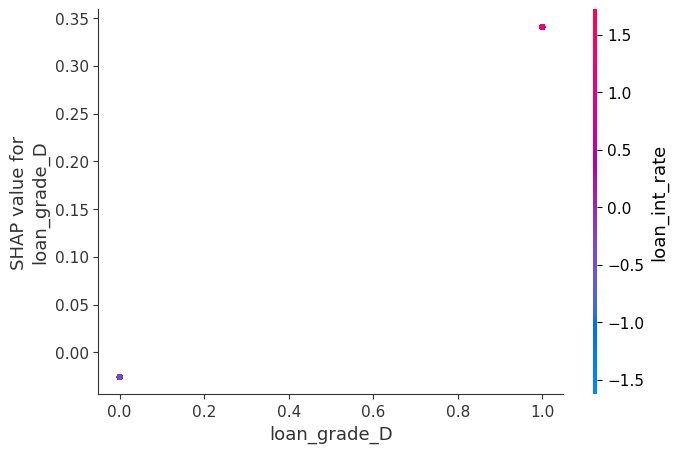

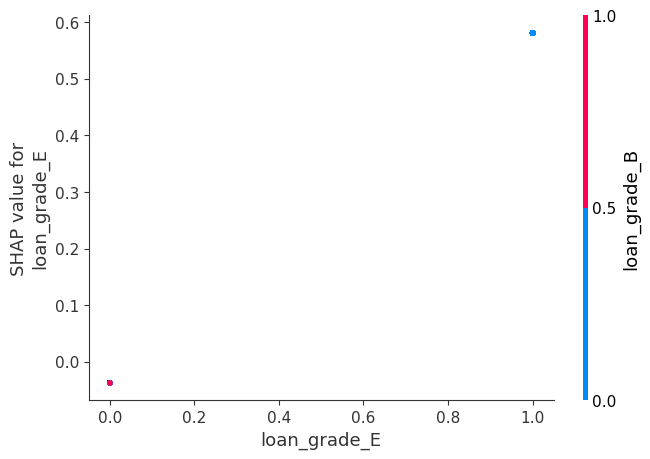

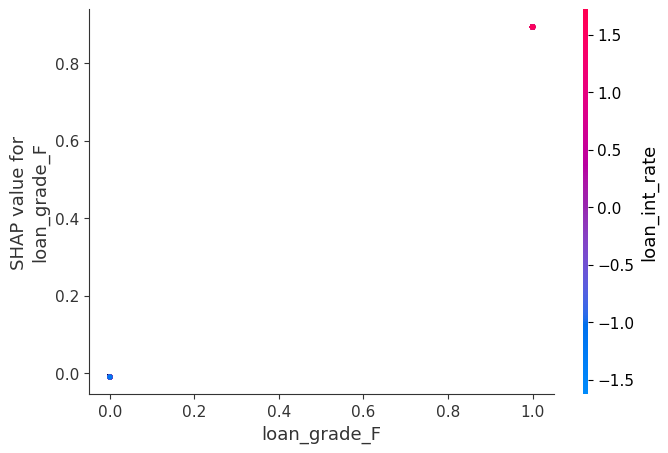

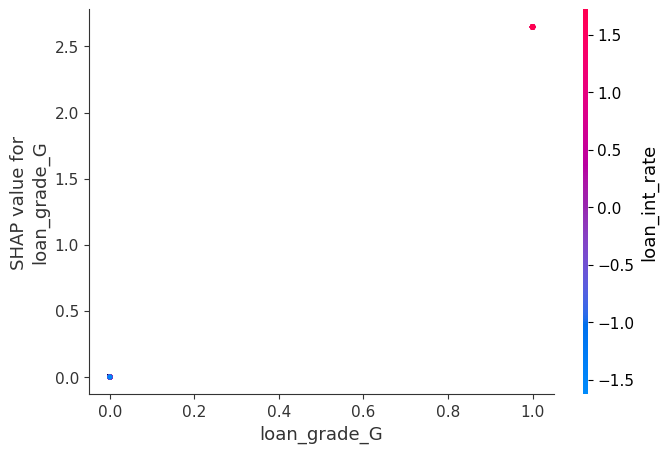

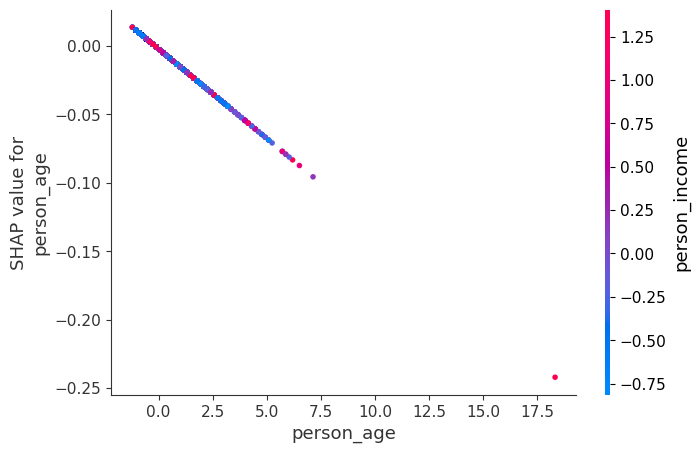

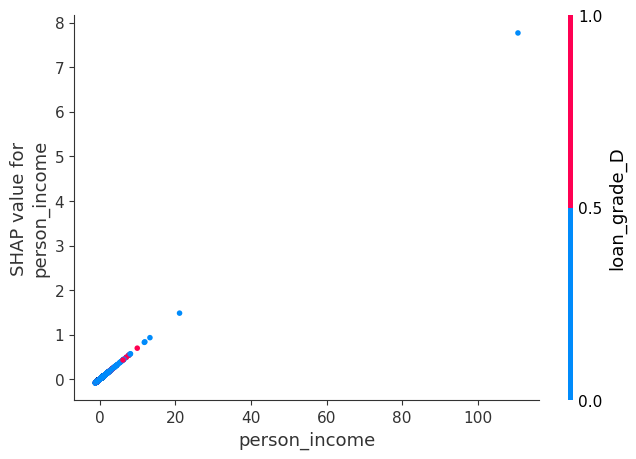

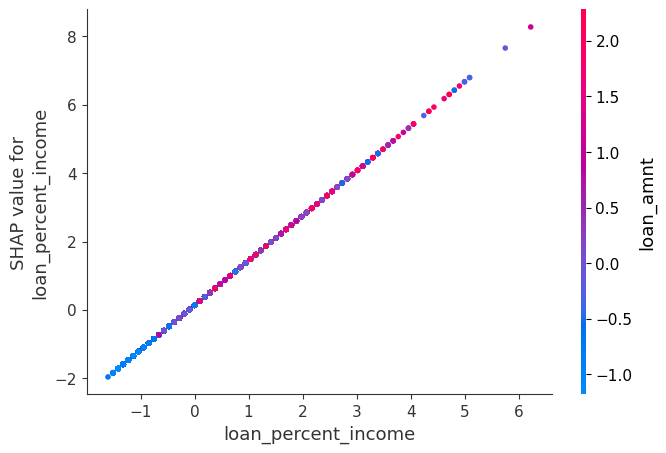

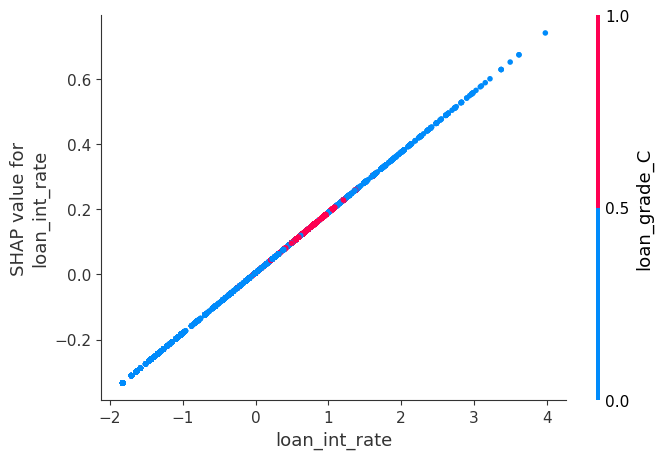

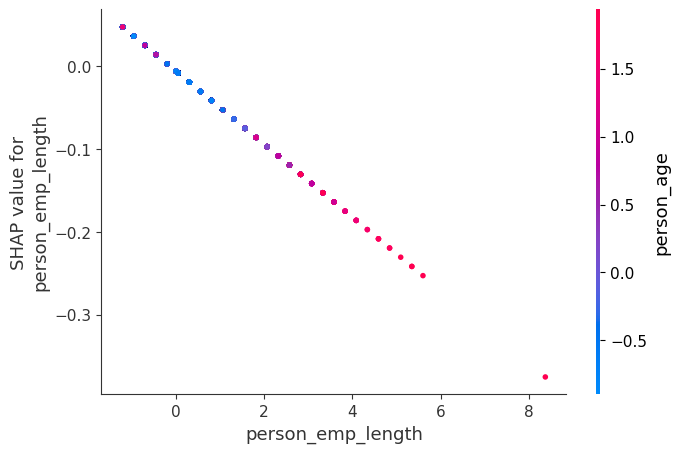

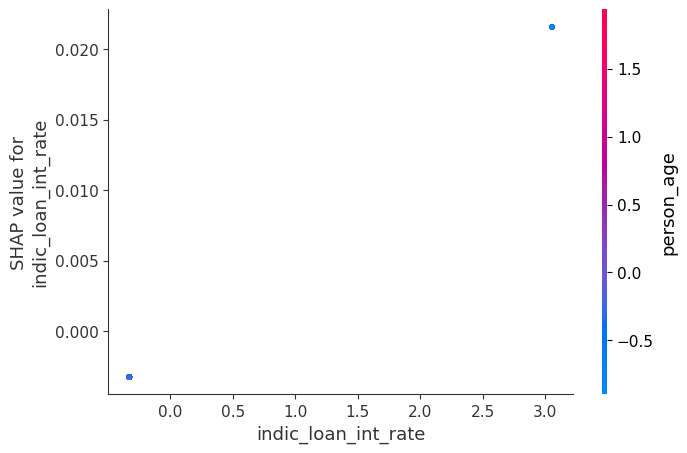

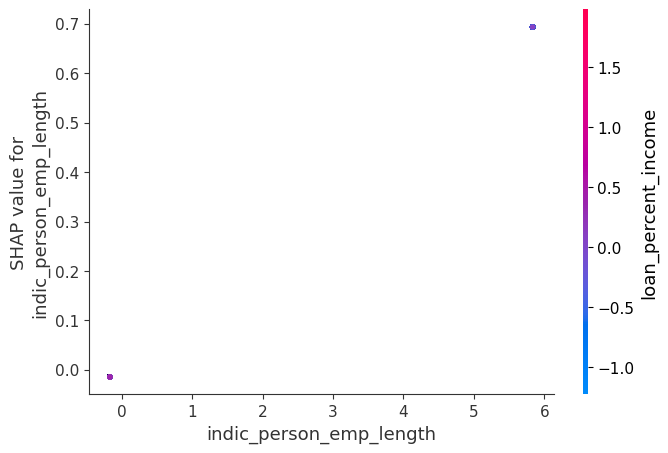

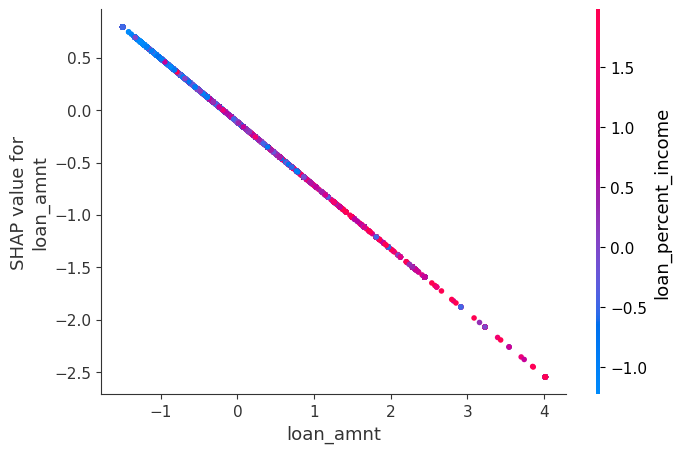

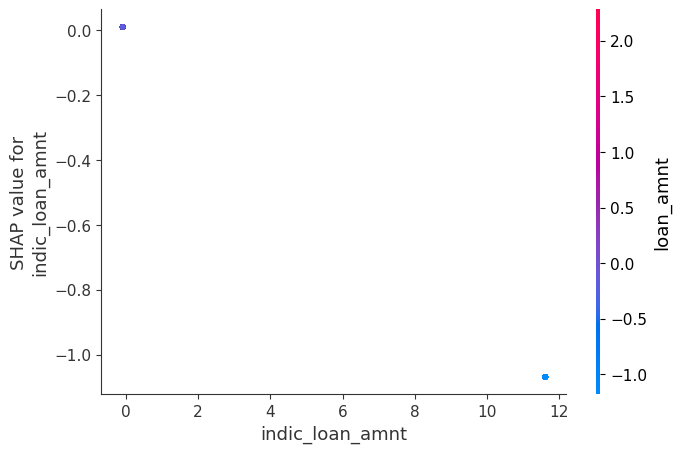

In [64]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values, X_test)

### Time of execution

In [65]:
end = time.time()

In [66]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 6 seconds.
